In [3]:
# Cargando las librerías necesarias
import numpy as np
import sklearn.feature_extraction
import sklearn.ensemble            # librería de algorítmos de conjuntos 
import pylab
import matplotlib.pyplot as plt
import tldextract                  # librería para manejar nombres de dominios
sklearn.__version__                # para mostrar la versión instalada de la librería

'0.19.2'

In [4]:
import pandas as pd
pd.__version__                     # para mostrar la versión instalada de la librería

'0.23.4'

In [6]:
# Configurar pylab para visualización que realizaremos más adelante
pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True

In [7]:
# Buscando ignorar mensajes de DeprecationWarning que usualmente aparecen en Pandas
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
# Esta es la lista de los primeros 100k dominios según Alexa. No utilizamos la lista completa, de 1M,
# por razones de velocidad. Pero si quieres probar, la lista completa esta disponible en el directorio
# data (en formato comprimido 7z)
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

rank           uri
0     1  facebook.com
1     2    google.com
2     3   youtube.com
3     4     yahoo.com
4     5     baidu.com

In [9]:
#Crear funcion para extraer el segundo nivel del dominio (2LD)
def domain_extract(uri):
    ext = tldextract.extract(uri)
     
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain
alexa_dataframe['domain'] = [domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
alexa_dataframe.head()            # esta funcion permite ver las primeras lineas del dataframe

domain
0  facebook
1    google
2   youtube
3     yahoo
4     baidu

In [10]:
alexa_dataframe.tail()

domain
99995  rhbabyandchild
99996              rm
99997            sat1
99998      nahimunkar
99999            musi

In [11]:
# Eliminar aquellas líneas con NaNs y líneas duplicadas
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()

# Añadir la columna con la clase de las muestras
alexa_dataframe['class'] = 'legit'

# Barajar los datos (importante para crear los sets de entrenamiento y evaluación)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print('Número Total de Dominios Alexa: %d' % alexa_total)

# Mantener el 10% de los datos para evaluación (hold out)
cutoff = int(alexa_total*.9)
hold_out_alexa = alexa_dataframe[cutoff:]
alexa_dataframe = alexa_dataframe[:cutoff]

print('Número de Dominios Alexa para Entrenamiento: %d' % alexa_dataframe.shape[0])

Número Total de Dominios Alexa: 91377
Número de Dominios Alexa para Entrenamiento: 82239


In [13]:
alexa_dataframe

domain  class
25979                         bodymedia  legit
13573                        videoxlist  legit
33061                          mangainn  legit
70495                       overallsite  legit
12453                       animeseason  legit
77204                         vibeobash  legit
81057                        chatbazaar  legit
46529                        empowernet  legit
74912                         securitas  legit
64937                              izea  legit
80954                    redlettermedia  legit
8342                        emirates247  legit
50808                           cago365  legit
30423                         mwananchi  legit
61783                          saskjobs  legit
82814                           ucaster  legit
74652                              idcc  legit
92957  americansforresponsiblesolutions  legit
57439                       beautybrite  legit
10791                          hulkload  legit
17820                 vakantieveilingen  legit
52923                  bestbridalprices  legit
40707                           arikair  legit
74107                   franchisedirect  legit
6209                          sexsearch  legit
15795                     rijksoverheid  legit
10328                    trafficfactory  legit
98618                    sterlingdirect  legit
7947                                sbb  legit
33021                           mengmai  legit
...                                 ...    ...
87201                         cashmetod  legit
67085                          mojohost  legit
6288                              wippy  legit
80594                 victorsaffiliates  legit
15565                         dzmusique  legit
47322                     driversupport  legit
95962                   engineeringnews  legit
31902                              ustb  legit
45532                     versiliawebtv  legit
26128                              dsqq  legit
17992                           kiwidir  legit
86735                       resultspage  legit
19149                            xxlmag  legit
73367                        atz-europa  legit
39129                         grtjewels  legit
14491                              yota  legit
26147                         jetsetmag  legit
36861                              dle9  legit
54174                     etiquettehell  legit
89485                        disinibiti  legit
80189                       fresh-hotel  legit
46767                      dlplayground  legit
99523                    clickpathtrack  legit
89085                           7trends  legit
40197                    hotlegsandfeet  legit
36236                  lehighvalleylive  legit
84334             comoganhardinheironet  legit
72908                   sumtotalsystems  legit
80842                          topbux88  legit
54840                   hellonepalkorea  legit

[82239 rows x 2 columns]

In [15]:
alexa_dataframe.head()

domain  class
67875  faceyourmanga  legit
1694     bancobrasil  legit
65501       xiaomayi  legit
46426      dooblerha  legit
59254        marchex  legit

In [16]:
alexa_dataframe.tail()

domain  class
71681  pinupgirlclothing  legit
7720           readwrite  legit
72134              snack  legit
7830       serienjunkies  legit
44625       thehendonmob  legit

In [17]:
# Crear dataframe que contiene los dominios DGA
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

# Necesario normalizar los dominios ya que algunos sólo difieren por capitalización o .com/.org/.info
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

# Eliminar aquellas lineas con NaNs y lineas duplicadas
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print('Número Total de Dominios DGA: %d' % dga_total)

# Añadir la columna con la clase de las muestras
dga_dataframe['class'] = 'dga'

# Mantener el 10% de los datos para evaluación (hold out)
cutoff_dga = int(dga_total*.9)
hold_out_dga = dga_dataframe[cutoff_dga:]
dga_dataframe = dga_dataframe[:cutoff_dga]

print('Número de Dominios DGA para Entrenamiento: %d' % dga_dataframe.shape[0])

Número Total de Dominios DGA: 2664
Número de Dominios DGA para Entrenamiento: 2397


In [18]:
dga_dataframe.head()

domain class
0  04055051be412eea5a61b7da8438be3d   dga
1                        1cb8a5f36f   dga
2  30acd347397c34fc273e996b22951002   dga
3  336c986a284e2b3bc0f69f949cb437cb   dga
5  40a43e61e56a5c218cf6c22aca27f7ee   dga

In [19]:
# Concatenar los dos archivos de entrenamiento
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)

In [20]:
# Añadir una columna de longitud para los dominios
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Tomamos la decisión de remover los dominios con longitud de hasta 6 caracteres,
# ya que hemos observado que estos no siguen nuestra idea de que los dominios
# DGA típicamente poseen una longitud mayor. Debido a esta decisión, nos estamos
# forzando a probablemente crear listas (white/black lists) para dominios cortos
all_domains = all_domains[all_domains['length'] > 6]

In [21]:
# Función tomada de Rosetta Code (rosettacode.org)
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [22]:
# Añadir una columna de entropía para los dominios
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

In [23]:
all_domains.head()

domain  class  length   entropy
0  faceyourmanga  legit      13  3.334679
1    bancobrasil  legit      11  3.095795
2       xiaomayi  legit       8  2.500000
3      dooblerha  legit       9  2.947703
4        marchex  legit       7  2.807355

In [24]:
all_domains.tail()

domain class  length   entropy
76407  ulxxqduryvv   dga      11  2.913977
76408     ummvzhin   dga       8  2.750000
76409     umsgnwgc   dga       8  2.750000
76410  umzsbhpkrgo   dga      11  3.459432
76411  umzuyjrfwyf   dga      11  2.913977

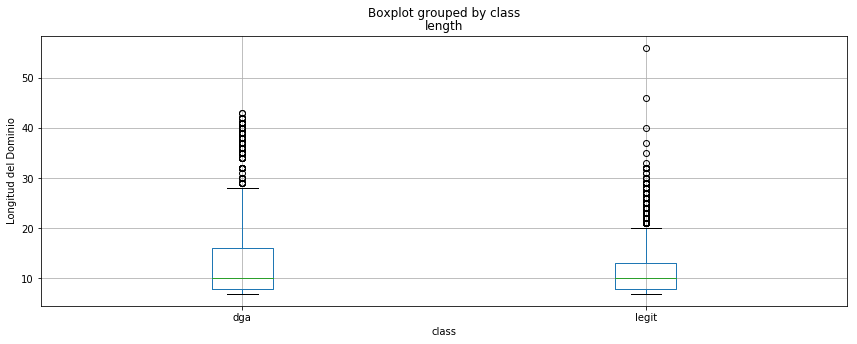

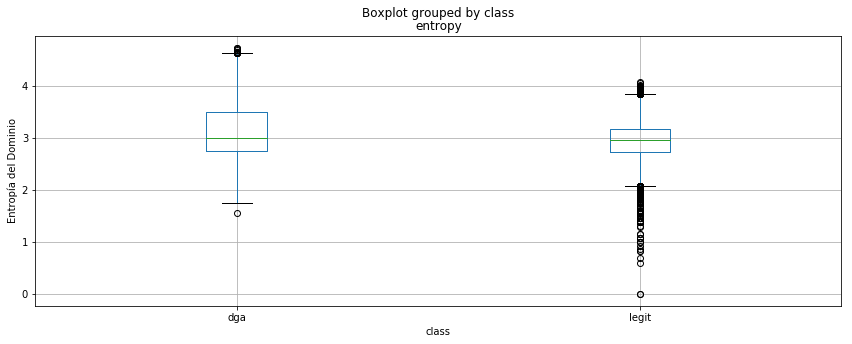

In [25]:
# El diagrama de caja (boxplots) muestra la distribución de los datos (propagación)
# https://es.wikipedia.org/wiki/Diagrama_de_caja

# Graficar la longitud y entropía de los dominios
all_domains.boxplot('length','class')
pylab.ylabel('Longitud del Dominio')
all_domains.boxplot('entropy','class')
pylab.ylabel('Entropía del Dominio')
plt.show()

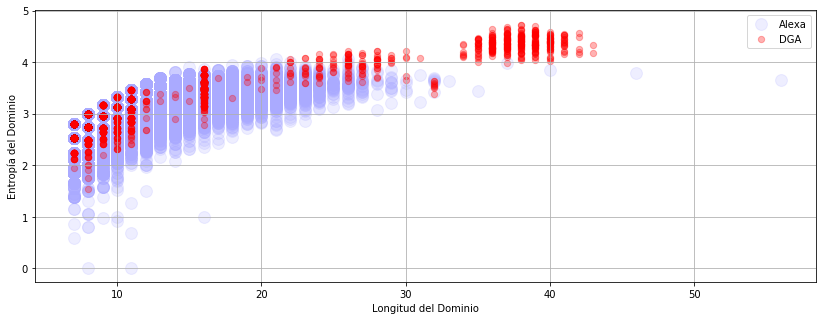

In [26]:
# Dividir las clases para poder establecer colores, tamaño y etiquetas de las muestras
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'], alexa['entropy'], s=140, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['entropy'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Longitud del Dominio')
pylab.ylabel('Entropía del Dominio')
plt.show()
# Se aprecia que en promedio, los dominios DGA tienden a mostrar mayor entropía que los de Alexa

In [27]:
# Veámos aquellos dominios que poseen una entropía mayor a 4
high_entropy_domains = all_domains[all_domains['entropy'] > 4]
print('No. Dominios con Entropía > 4: %.2f%% %d (de un total de %d)' % (100.0*high_entropy_domains.shape[0]/all_domains.shape[0],high_entropy_domains.shape[0],all_domains.shape[0]))
print("No. Dominios Legítimos con Alta Entropía: %d" % high_entropy_domains[high_entropy_domains['class']=='legit'].shape[0])
print("No. Dominios DGA con Alta Entropía: %d" % high_entropy_domains[high_entropy_domains['class']=='dga'].shape[0])
high_entropy_domains[high_entropy_domains['class']=='legit'].head()

# Los resultados de abajo muestran que hay más dominios en el grupo DGA
# con alta entropía, pero sólo un pequeño porcentaje de todos los dominios
# DGA poseen alta entropía

No. Dominios con Entropía > 4: 0.63% 361 (de un total de 56873)
No. Dominios Legítimos con Alta Entropía: 3
No. Dominios DGA con Alta Entropía: 358


domain  class  length   entropy
38633      burzhunetdlyachaynikov  legit      22  4.004886
61195  congresomundialjjrperu2009  legit      26  4.056021
68783       theukwebdesigncompany  legit      21  4.070656

In [29]:
# En preparación para usar scikit-learn, vamos a convertir las 
# estructuras de datos de Panda, a formato para scikit (np-array)

# Matriz con vectores de muestras (scikit learn usa la convención 'X' como nombre de la matriz de muestras)
X = all_domains.as_matrix(['length', 'entropy'])

# Etiquetas (usamos la convención 'y' para etiquetas de las clases)
y = np.array(all_domains['class'].tolist()) # Yes, this is weird but it needs 
                                            # to be an np.array of strings

/home/jam620/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [30]:
# Random Forest es un popular clasificador de aprendizaje de máquinas, de método de conjunto (ensemble)
# http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) # Número de arboles en la foresta

In [31]:
# Utilizamos los métodos de validación cruzada de scikit-learn para estimar el rendimiento
# predictivo del modelo Random Forest
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5, n_jobs=4)
print(scores)

[0.96501406 0.96465934 0.96641463 0.96518375 0.9600844 ]


In [32]:
# Debemos hacer un análisis más profundo del rendimiento del clasificador

# Dividimos la data en 80% para entrenamiento y 20% para evaluación (80/20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Estadísticas de la Matriz de Confusión
legit/legit: 99.81% (10893/10914)
legit/dga: 0.19% (21/10914)
dga/legit: 81.78% (377/461)
dga/dga: 18.22% (84/461)


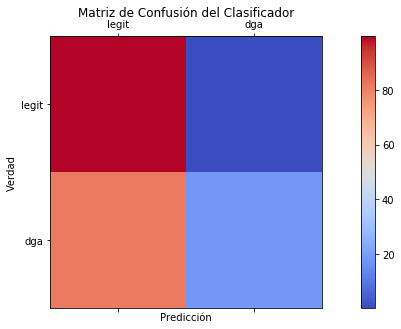

In [33]:
# Ahora graficamos los resultados de la data 80/20 en una matriz de confusión
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Calcular los porcentajes
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print('Estadísticas de la Matriz de Confusión')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Mostrar la matriz de confusión
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Matriz de Confusión del Clasificador')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicción')
    pylab.ylabel('Verdad')
    pylab.show()

plot_cm(cm, labels)
# https://en.wikipedia.org/wiki/Confusion_matrix

# Ahora vemos que nuestras sospechas eran correctas y que el clasificador
# está marcando casi todos las muestras como legítimas. Hemos fallado... 
# la ciencia es dura... hora de tomar una cerveza...

In [34]:
# Recibimos apoyo de nuestra madre por lo que continuaremos y ahora
# calcularemos NGrams para cada dominio 'legítimo' y veremos si podemos
# usar NGrams para ayudarnos a diferenciar y detectar dominios DGA...

# Scikit-learn brinda un buen generador de NGrams que puede crear NGrams de 
# caracteres o NGrams de palabras. Usaremos de caracteres.
# Parámetros:
#       - ngram_range=(3,5)  # Produce todos los ngrams de longitud 3, 4, y 5
#       - min_df=1e-4        # Mínima frecuencia de documentos. Usar 1e-4 estamos
#                            # diciendo que deseamos obtener NGrams que han
#                            # ocurrido en al menos el .1% de los dominios
#                            # (para 100k dominios, son al menos 100)
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)

In [37]:
# Existe una mejor manera de almacenar todos los conteos...
# Al menos el parámetro min_df produce algunos recortes (thresholding)
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [38]:
import operator
_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), key=operator.itemgetter(1), reverse=True)
print('Alexa NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Alexa NGrams: 24421
ing 3.346548558548474
lin 3.3330440298234874
ine 3.311541958401195
tor 3.172310968521954
ter 3.1705550585212086
ion 3.15259407792747
ent 3.1455071714096627
the 3.1099158630237933
por 3.1078880251827985
tra 3.073351702386901


In [39]:
# Vamos a crear un dataframe con palabras de un diccionario
word_dataframe = pd.read_csv('data/words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# Limpiar palabras del diccionario
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
# https://help.qlik.com/es-ES/sense/June2018/Subsystems/Hub/Content/Scripting/MappingFunctions/ApplyMap.htm
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
word_dataframe.head(10)

word
37       a
48      aa
51     aaa
53    aaaa
54  aaaaaa
55    aaal
56    aaas
57  aaberg
58  aachen
59     aae

In [40]:
# Ahora calculemos NGrams sobre las palabras del diccionario
# Igual proceso al de arriba
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.log10.html

In [41]:
# Ordenemos los NGrams y mostrémoslos
_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key=operator.itemgetter(1), reverse=True)
print('Word NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Word NGrams: 123061
ing 4.387300822448285
ess 4.204879333760662
ati 4.1933472563864616
ion 4.165036479994566
ter 4.162415036106447
nes 4.112504458767161
tio 4.076822423342773
ate 4.0723602039634885
ent 4.069631102620343
tion 4.0496056125949735


In [42]:
# Usamos el método transform de la clase CountVectorizer para crear un
# vector de ngrams que existen en el dominio. El vector luego es multiplicado
# por el vector count (el cual es una suma por columna de la matriz count)
def ngram_count(domain):
    alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot vector multiply and transpose Woo Hoo!
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print('{0:25s} - Alexa match:{1:3d} - Dict match:{2:3d}'.format(domain, int(alexa_match), int(dict_match)))

# Examples:
ngram_count('google')
ngram_count('facebook')
ngram_count('1cb8a5f36f')
ngram_count('pterodactylfarts')
ngram_count('ptes9dro-dwacty2lfa5rrts')
ngram_count('beyonce')
ngram_count('bey666on4ce')

google                    - Alexa match: 16 - Dict match: 14
facebook                  - Alexa match: 29 - Dict match: 27
1cb8a5f36f                - Alexa match:  0 - Dict match:  0
pterodactylfarts          - Alexa match: 33 - Dict match: 76
ptes9dro-dwacty2lfa5rrts  - Alexa match: 18 - Dict match: 28
beyonce                   - Alexa match: 14 - Dict match: 16
bey666on4ce               - Alexa match:  2 - Dict match:  1


In [43]:
# Calcular los pareos NGram para todos los dominios y añadir al dataframe
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains.head()

domain  class  length   entropy  alexa_grams  word_grams
0  faceyourmanga  legit      13  3.334679    40.831951   49.688640
1    bancobrasil  legit      11  3.095795    34.616637   46.351981
2       xiaomayi  legit       8  2.500000    13.619698   13.532712
3      dooblerha  legit       9  2.947703    15.996168   25.854815
4        marchex  legit       7  2.807355    20.735456   28.753658

In [44]:
all_domains.tail()

domain class  length   entropy  alexa_grams  word_grams
76407  ulxxqduryvv   dga      11  2.913977     3.658679    6.464859
76408     ummvzhin   dga       8  2.750000     6.078768    7.180022
76409     umsgnwgc   dga       8  2.750000     3.120574    3.847079
76410  umzsbhpkrgo   dga      11  3.459432     1.633468    2.546543
76411  umzuyjrfwyf   dga      11  2.913977     0.000000    0.000000

In [45]:
# Usar las operaciones vectorizadas del dataframe para investigar las diferencias
# entre los grams de alexa y los de las palabras
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
all_domains.sort_values(['diff'], ascending=True).head(10)

# La tabla de abajo muestra aquellos nombres de dominio que son parecidos a
# el diccionario y menos al web

domain  class  length   entropy  alexa_grams  \
11114  bipolardisorderdepressionanxiety  legit      32  3.616729   111.108089   
70154  americansforresponsiblesolutions  legit      32  3.667838   143.362392   
21320     channel4embarrassingillnesses  legit      29  3.440070    94.529121   
74270        canadianpharmaceuticalsorg    dga      26  3.690260    80.493099   
53052       annamalicesissyselfhypnosis  legit      27  3.429908    63.985912   
24872            foreclosurephilippines  legit      22  3.447402    69.891033   
63710           egaliteetreconciliation  legit      23  3.186393    90.003405   
72157               pragmatismopolitico  legit      19  3.326360    59.437416   
32118           interoperabilitybridges  legit      23  3.588354    92.132860   
52078       mythoughtsideasandramblings  legit      27  3.884155    95.753549   

       word_grams       diff  
11114  190.833856 -79.725767  
70154  218.363956 -75.001564  
21320  169.119440 -74.590319  
74270  143.316082 -62.822984  
53052  126.667692 -62.681780  
24872  132.514638 -62.623605  
63710  152.125325 -62.121920  
72157  121.536223 -62.098807  
32118  153.626312 -61.493452  
52078  156.295588 -60.542039

In [46]:
all_domains.sort_values(['diff'], ascending=False).head(20)

# La tabla de abajo muestra aquellos nombres de dominio que son más tipo web y menos
# de diccionario...

domain  class  length  \
68341  gay-sex-pics-porn-pictures-gay-sex-porn-gay-se...  legit      56   
36337                          stream-free-movies-online  legit      25   
39822                            watch-free-movie-online  legit      23   
2410                                web-directory-online  legit      20   
20728     article-directory-free-submission-free-content  legit      46   
9087                               free-online-directory  legit      21   
48629                      social-bookmarking-sites-list  legit      29   
65792                               online-web-directory  legit      20   
18969                                xxx-porno-sexvideos  legit      19   
55077                                  movie-news-online  legit      17   
51424                          best-online-shopping-site  legit      25   
33446                               free-tv-video-online  legit      20   
69150                            freegamesforyourwebsite  legit      23   
52657                             free-web-mobile-themes  legit      22   
20472                            web-link-directory-site  legit      23   
57175                                freewebsite-service  legit      19   
44168                              seowebdirectoryonline  legit      21   
59343                                download-free-games  legit      19   
51763                            social-bookmarking-site  legit      23   
60765                                  free-sexvideosfc2  legit      17   

        entropy  alexa_grams  word_grams       diff  
68341  3.661056   154.386467   85.124184  69.262282  
36337  3.509275   115.422184   74.496915  40.925268  
39822  3.708132    98.944287   58.943451  40.000836  
2410   3.584184   112.236626   74.082948  38.153678  
20728  3.786816   226.366692  188.230453  38.136239  
9087   3.403989   118.692381   80.735030  37.957350  
48629  3.702472   140.073452  102.261826  37.811627  
65792  3.584184   111.889756   74.082948  37.806807  
18969  3.260828    71.983624   34.574489  37.409135  
55077  3.175123    78.495569   41.705735  36.789833  
51424  3.452879   116.072312   79.596640  36.475672  
33446  3.284184    81.653629   45.662984  35.990644  
69150  3.551191   111.106292   77.311761  33.794531  
52657  3.356492    86.389550   54.149725  32.239825  
20472  3.729446   101.071804   69.367186  31.704619  
57175  3.115834    95.322236   64.263812  31.058424  
44168  3.499228   122.875427   91.819498  31.055930  
59343  3.576618    81.669396   50.661490  31.007905  
51763  3.762267   114.566053   83.942961  30.623092  
60765  3.381580    61.819555   31.276372  30.543183

Text(0,0.5,'No. de Coincidencias con Alexa NGrams')

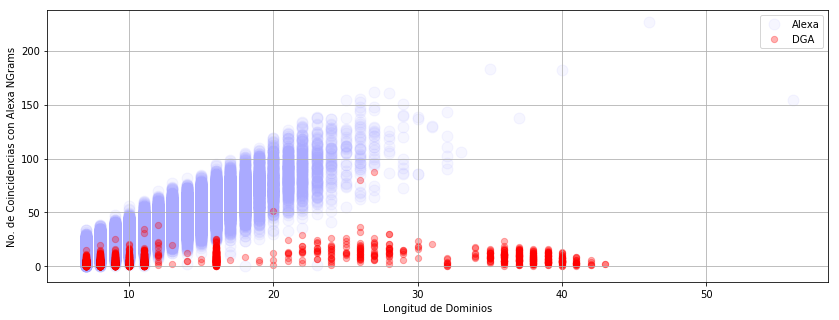

In [47]:
# Vamos a graficar
# Aquí deseamos ver si nuestra característica alexa_grams puede ayudarnos a diferenciar
# entre legítimo y DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['alexa_grams'], s=120, c='#aaaaff', label='Alexa', alpha=.1)
plt.scatter(dga['length'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Longitud de Dominios')
pylab.ylabel('No. de Coincidencias con Alexa NGrams')